In [1]:
import numpy as np
import math as m
from matplotlib import pyplot as plt

In [2]:
def top(nelx, nely, volfrac, penal, rmin):
    # INITIALIZE
    x = volfrac*(np.ones((nely,nelx))) # density matrix
    loop = 0
    change = 1
    dc= np.ones((nely,nelx)) # Sensitivity matrix
    # start iteration
    while change > 0.01:
        loop = loop+1
        xold = x
        # FE-ANALYSIS
        U = FE(nelx,nely,x,penal)
        #OBJECTIVE FUNCTION AND SENSITIVITY ANALYSIS
        KE = lk()
        c = 0
        for ely in range(0,nely):
            for elx in range(0,nelx):
                n1 = (nely+1)*(elx)+ely+1
                n2 = (nely+1)* (elx+1)   +ely+1
                Ue = U[[2*n1-2,2*n1-1, 2*n2-2,2*n2-1, 2*n2,2*n2+1, 2*n1,2*n1+1]]
                c = c + ((x[ely,elx])**penal)*np.dot(np.dot((np.transpose(Ue)),KE),Ue)
                dc[ely,elx] = -penal*x[ely,elx]**(penal-1)*np.dot(np.dot((np.transpose(Ue)),KE),Ue)
        # FILTERING THE SENSITIVITIES
        dc = filter(nelx,nely,rmin,x,dc);
        
        # UPDATE DESIGN BY THE OPTIMALITY CRITERIA METHOD
        x = OC(nelx,nely,x,volfrac,dc);
        
        # PRINT RESULTS
        change = np.amax(np.abs(x-xold))
        print(f"It.: {loop}.  Obj.: {c}, vol:. {np.sum(x)/(nelx*nely)} ch.: {change}")
        plt.imshow(-x, cmap= "gray")
        plt.imsave(f'Step {loop}.png', -x, cmap="gray")
    

In [3]:
################OPTIMALITY CRITERIA UPDATE ############################
def OC(nelx,nely,x,volfrac,dc):
    l1 = 0; l2 = 100000; move = 0.2
    while ((l2-l1) > 1e-4):
        lmid = 0.5*(l2+l1);
        xnew = np.maximum(0.001,np.maximum(x-move,np.minimum(1,np.minimum(x+move,x*np.sqrt(-dc/lmid)))))
        if sum(sum(xnew)) - volfrac*nelx*nely > 0:
            l1 = lmid
        else:
            l2 = lmid
    return xnew

In [4]:
################# MESH-INDEPENDENCY FILTER ###########################
def filter(nelx,nely,rmin,x,dc):
    dcn=np.zeros((nely,nelx))
    for i in range(0,nelx):
        for j in range(0,nely):
            sum=0.0
            for k in range(max((i+1)-m.floor(rmin),1),min((i+1)+m.floor(rmin),nelx)+1):
                for l in range(max((j+1) - m.floor(rmin), 1),min((j+1) + m.floor(rmin), nely)+1):
                    fac = rmin-m.sqrt(((i+1)-k)**2 + ((j+1)-l)**2)
                    sum = sum+max(0,fac)
                    dcn[j,i] = dcn[j,i]+ max(0,fac)*x[l-1,k-1]* dc[l-1,k-1]
            dcn[j,i] = dcn[j,i]/(x[j,i]*sum) # Filtered Sensitivity matrix
    return dcn

In [5]:
################ FE-ANALYSIS ##########################
from scipy.sparse import csr_matrix
def FE(nelx,nely,x,penal):
    KE = lk()
    K = csr_matrix((2*(nelx+1)*(nely+1), 2*(nelx+1)*(nely+1))).toarray() # Global Stiffness matrix
    F = csr_matrix((2*(nely+1)*(nelx+1),1)).toarray() # Force vector
    U = np.zeros((2*(nely+1)*(nelx+1),1)); # Globle displacement vector
    for elx in range(0,nelx):
        for ely in range(0,nely):
            n1 = (nely+1)*(elx)+ely+1; 
            n2 = (nely+1)*(elx+1)   +ely+1;
            edof = [2*n1-2, 2*n1-1, 2*n2-2, 2*n2-1, 2*n2, 2*n2+1, 2*n1, 2*n1+1]
            K[np.ix_(edof,edof)] = (K[edof,:][:,edof]) + ((x[ely,elx]**penal)*KE);
    
    # DEFINE LOADS AND SUPPORTS (HALF MBB-BEAM)
    F[1,0] = -1
    fixeddofs = np.array(list(set().union([i for i in range(0,2*(nely+1),2)],[2*(nelx+1)*(nely+1)-1])))
    alldofs= np.arange(0,(2*(nely+1)*(nelx+1)))
    freedofs =np.array(list(set(alldofs).symmetric_difference(set(fixeddofs))))
    
    # SOLVING
    U[freedofs,:] = np.dot(np.linalg.inv(K[freedofs,:][:,freedofs]) ,F[freedofs,:])
    U[fixeddofs,:]= 0
    return U     

In [6]:
###################### ELEMENT STIFFNESS MATRIX ########################
def lk():
    E = 1.
    nu = 0.3
    k=[0, 1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8];
    r = np.array([[k[1], k[2], k[3], k[4], k[5], k[6], k[7], k[8]],
                     [k[2], k[1], k[8], k[7], k[6], k[5], k[4], k[3]],
                     [k[3], k[8], k[1], k[6], k[7], k[4], k[5], k[2]],
                     [k[4], k[7], k[6], k[1], k[8], k[3], k[2], k[5]],
                     [k[5], k[6], k[7], k[8], k[1], k[2], k[3], k[4]],
                     [k[6], k[5], k[4], k[3], k[2], k[1], k[8], k[7]],
                     [k[7], k[4], k[5], k[2], k[3], k[8], k[1], k[6]],
                     [k[8], k[3], k[2], k[5], k[4], k[7], k[6], k[1]]])
    KE = (E/(1-nu**2))*r # Element Stiffness matrix
    return KE

It.: 1.  Obj.: [[1007.02210779]], vol:. 0.5000022140250789 ch.: 0.2
It.: 2.  Obj.: [[579.55979964]], vol:. 0.49999430609599227 ch.: 0.20000000000000007
It.: 3.  Obj.: [[412.5077545]], vol:. 0.4999932553618248 ch.: 0.20000000000000007
It.: 4.  Obj.: [[343.98833781]], vol:. 0.500011361070829 ch.: 0.20000000000000007
It.: 5.  Obj.: [[322.03444133]], vol:. 0.5000097003975312 ch.: 0.1934834725265353
It.: 6.  Obj.: [[308.47064419]], vol:. 0.49998745888493334 ch.: 0.20000000000000007
It.: 7.  Obj.: [[298.56637414]], vol:. 0.4999989292495534 ch.: 0.17053865096216547
It.: 8.  Obj.: [[289.09540863]], vol:. 0.5000038954289138 ch.: 0.1915649393799581
It.: 9.  Obj.: [[280.66217123]], vol:. 0.4999910635748885 ch.: 0.13142024675972863
It.: 10.  Obj.: [[272.65526777]], vol:. 0.5000007352782571 ch.: 0.13069552996245648
It.: 11.  Obj.: [[265.38792158]], vol:. 0.5000053623170005 ch.: 0.16037418725332786
It.: 12.  Obj.: [[257.33576609]], vol:. 0.5000135006950794 ch.: 0.16715266708245513
It.: 13.  Obj.: [[

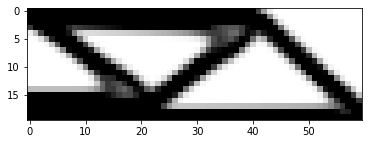

In [7]:
top(60,20,0.5,3.0,1.5)